In [1]:
from icevision.all import *
import pandas as pd

In [2]:
torch.cuda.is_available()

True

In [3]:
data_dir = Path('data_full/data')

In [4]:
data_dir.ls()

(#1014) [Path('data_full/data/screen_275.png'),Path('data_full/data/screen_64.png'),Path('data_full/data/screen_751.png'),Path('data_full/data/screen_555.png'),Path('data_full/data/screen_713.png'),Path('data_full/data/screen_872.png'),Path('data_full/data/screen_807.png'),Path('data_full/data/screen_245.png'),Path('data_full/data/screen_811.png'),Path('data_full/data/screen_260.png')...]

In [5]:
faults_filepath = data_dir / 'faultsScreen.csv'
panels_filepath = data_dir / 'panelsScreen.csv'

In [6]:
faults_df = pd.read_csv(faults_filepath, names=['img', 'panel', 'x', 'y', 'camera_distance', 'severity'])

In [7]:
faults_df.head()

img  panel          x         y  camera_distance  severity
0    0      1   855.9756  562.9597         5.856124  1.799800
1    0      1  1039.9300  395.7225         5.180756  2.672946
2    0      2   596.5045  417.9025         5.239655  1.682775
3    0      2   565.5096  452.0289         5.368117  3.571864
4    0      2   565.5358  393.3857         5.153532  1.959562

In [8]:
panels_df = pd.read_csv(panels_filepath, names=['img', 'panel', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])

In [9]:
panels_df.head()

img  panel         x1        y1        z1         x2        y2        z2  \
0    0      0  1448.7830  302.3929  4.848379  1344.1570  565.2280  5.829680   
1    0      1  1120.1490  307.8406  4.885396  1071.1520  568.1060  5.866697   
2    0      2   790.6816  309.4182  4.865339   796.8146  570.3117  5.846640   
3    0      3   469.0962  312.0494  4.886778   528.9846  571.5497  5.868079   
4    1      0  1448.7830  302.3929  4.848379  1344.1570  565.2280  5.829680   

          x3        y3        z3         x4        y4        z4  
0  1173.2190  304.6540  4.866513  1115.1590  566.2947  5.847815  
1   847.8801  310.0645  4.903530   844.4354  569.1571  5.884832  
2   518.5185  311.6453  4.883473   570.1711  571.3596  5.864774  
3   199.3117  314.2570  4.904912   303.9917  572.5899  5.886213  
4  1173.2190  304.6540  4.866513  1115.1590  566.2947  5.847815

In [10]:
imgs_filepaths = get_image_files(data_dir)

In [11]:
# keep only the rows that have images
imgs_idxs = [int(o.stem.split('_')[-1]) for o in imgs_filepaths]
faults_df = faults_df.loc[faults_df['img'].isin(imgs_idxs)]
panels_df = panels_df.loc[panels_df['img'].isin(imgs_idxs)]

In [12]:
class FullParser(parsers.Parser, parsers.FilepathMixin, parsers.BBoxesMixin, parsers.LabelsMixin):
    def __init__(self, data_dir):
        faults_filepath = data_dir / 'faultsScreen.csv'
        
        self.data_dir = data_dir
        self.faults_df = pd.read_csv(faults_filepath, names=['img', 'panel', 'x', 'y', 'camera_distance', 'severity'])
        self.is_fault = True
        
    def __iter__(self) -> Any:
        # TODO: using global variable
        for item in faults_df.itertuples():
            yield item
            
        self.is_fault = False
        for item in panels_df.itertuples():
            yield item
        
    def imageid(self, o) -> Hashable:
        return o.img
        
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def filepath(self, o) -> Union[str, Path]:
        return self.data_dir / f'screen_{o.img}.png'
        
    def labels(self, o) -> List[int]:
        return [2] if self.is_fault else [1]
    
    def bboxes(self, o) -> List[BBox]:
        if self.is_fault:
            x = o.x
            y = 908 - o.y
            return [BBox.from_xyxy(x-1, y-1, x+1, y+1)]
        else:
            xs = (o.x1, o.x2, o.x3, o.x4)
            xmin, xmax = min(xs), max(xs)

            ys = 908 - np.array((o.y1, o.y2, o.y3, o.y4))
            ymin, ymax = min(ys), max(ys)

            return [BBox.from_xyxy(xmin, ymin, xmax, ymax)]

In [13]:
full_parser = FullParser(data_dir)
# panel_parser = PanelParser(data_dir)

In [14]:
# fault_train_records, fault_valid_records = fault_parser.parse()
train_records, valid_records = full_parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:124
AUTOFIX-START - ️🔨  Autofixing record with imageid: 480  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 1012.7828 to image height 908 (Before: <BBox (xmin:743.9202, ymin:478.3285, xmax:1223.006, ymax:1012.7828)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 519  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 973.99652 to image height 908 (Before: <BBox (xmin:701.1260000000001, ymin:572.1599, xmax:1096.586, ymax:973.99652)>) | icevision.core.bbox:autofix:86


AUTOFIX-START - ️🔨  Autofixing record with imageid: 529  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 947.90094 to image height 908 (Before: <BBox (xmin:705.7526, ymin:578.1684, xmax:1080.423, ymax:947.90094)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 526  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 973.99652 to image height 908 (Before: <BBox (xmin:701.1260000000001, ymin:572.1599, xmax:1096.586, ymax:973.99652)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 966  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymin from -5.328600000000051 to 0 (Before: (<BBox (xmin:268.7224, ymin:-5.328600000000051, xmax:820.6105, ymax:451.0583)>)) | icevision.core.bbox:autofix:72
AUTOFIX-START - ️🔨  Autofixing record with imageid: 535  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax f

AUTOFIX-START - ️🔨  Autofixing record with imageid: 497  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 1022.4428 to image height 908 (Before: <BBox (xmin:724.9416, ymin:515.6632, xmax:1186.499, ymax:1022.4428)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 975  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymin from -7.4909000000000106 to 0 (Before: (<BBox (xmin:251.5376, ymin:-7.4909000000000106, xmax:777.0619, ymax:435.2297)>)) | icevision.core.bbox:autofix:72
AUTOFIX-START - ️🔨  Autofixing record with imageid: 470  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 985.4541 to image height 908 (Before: <BBox (xmin:766.2194, ymin:432.7101, xmax:1257.755, ymax:985.4541)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 970  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymin from -7.49

AUTOFIX-SUCCESS - Clipping bbox ymin from -7.4909000000000106 to 0 (Before: (<BBox (xmin:251.5376, ymin:-7.4909000000000106, xmax:777.0619, ymax:435.2297)>)) | icevision.core.bbox:autofix:72
AUTOFIX-START - ️🔨  Autofixing record with imageid: 528  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 947.90094 to image height 908 (Before: <BBox (xmin:705.7526, ymin:578.1684, xmax:1080.423, ymax:947.90094)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 507  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 989.79981 to image height 908 (Before: <BBox (xmin:925.3259, ymin:987.79981, xmax:927.3259, ymax:989.79981)>) | icevision.core.bbox:autofix:86
AUTOFIX-FAIL - Cannot auto-fix coordinates: <BBox (xmin:925.3259, ymin:987.79981, xmax:927.3259, ymax:908)>
	y_min:987.79981 is greater than or equal to y_max:908 | icevision.core.record_mixins:_autofix:155
AUTOFIX-SUCCESS - Clipping bbox yma

AUTOFIX-START - ️🔨  Autofixing record with imageid: 471  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 985.4541 to image height 908 (Before: <BBox (xmin:766.2194, ymin:432.7101, xmax:1257.755, ymax:985.4541)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 543  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 924.45766 to image height 908 (Before: <BBox (xmin:715.0692, ymin:582.4707000000001, xmax:1071.5839999999998, ymax:924.45766)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 537  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 947.90094 to image height 908 (Before: <BBox (xmin:705.7526, ymin:578.1684, xmax:1080.423, ymax:947.90094)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 465  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox yma

AUTOFIX-SUCCESS - Clipping bbox ymax from 1012.7828 to image height 908 (Before: <BBox (xmin:743.9202, ymin:478.3285, xmax:1223.006, ymax:1012.7828)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 971  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymin from -7.4909000000000106 to 0 (Before: (<BBox (xmin:251.5376, ymin:-7.4909000000000106, xmax:777.0619, ymax:435.2297)>)) | icevision.core.bbox:autofix:72
AUTOFIX-START - ️🔨  Autofixing record with imageid: 475  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 985.4541 to image height 908 (Before: <BBox (xmin:766.2194, ymin:432.7101, xmax:1257.755, ymax:985.4541)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 964  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymin from -5.328600000000051 to 0 (Before: (<BBox (xmin:268.7224, ymin:-5.328600000000051, xmax:820.6105, ymax:451

AUTOFIX-START - ️🔨  Autofixing record with imageid: 959  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymin from -5.328600000000051 to 0 (Before: (<BBox (xmin:268.7224, ymin:-5.328600000000051, xmax:820.6105, ymax:451.0583)>)) | icevision.core.bbox:autofix:72
AUTOFIX-START - ️🔨  Autofixing record with imageid: 536  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 947.90094 to image height 908 (Before: <BBox (xmin:705.7526, ymin:578.1684, xmax:1080.423, ymax:947.90094)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 540  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 924.45766 to image height 908 (Before: <BBox (xmin:715.0692, ymin:582.4707000000001, xmax:1071.5839999999998, ymax:924.45766)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 469  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping b

AUTOFIX-SUCCESS - Clipping bbox ymax from 924.45766 to image height 908 (Before: <BBox (xmin:715.0692, ymin:582.4707000000001, xmax:1071.5839999999998, ymax:924.45766)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 511  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 998.49483 to image height 908 (Before: <BBox (xmin:702.6506, ymin:561.4646, xmax:1120.542, ymax:998.49483)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 542  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 924.45766 to image height 908 (Before: <BBox (xmin:715.0692, ymin:582.4707000000001, xmax:1071.5839999999998, ymax:924.45766)>) | icevision.core.bbox:autofix:86
AUTOFIX-START - ️🔨  Autofixing record with imageid: 499  ️🔨 | icevision.core.record:_pre_replay:86
AUTOFIX-SUCCESS - Clipping bbox ymax from 1016.3361 to image height 908 (Before: <BBox (xmin:710.7697, ymin:543.2

In [17]:
class_map = ClassMap(['panel', 'fault'])

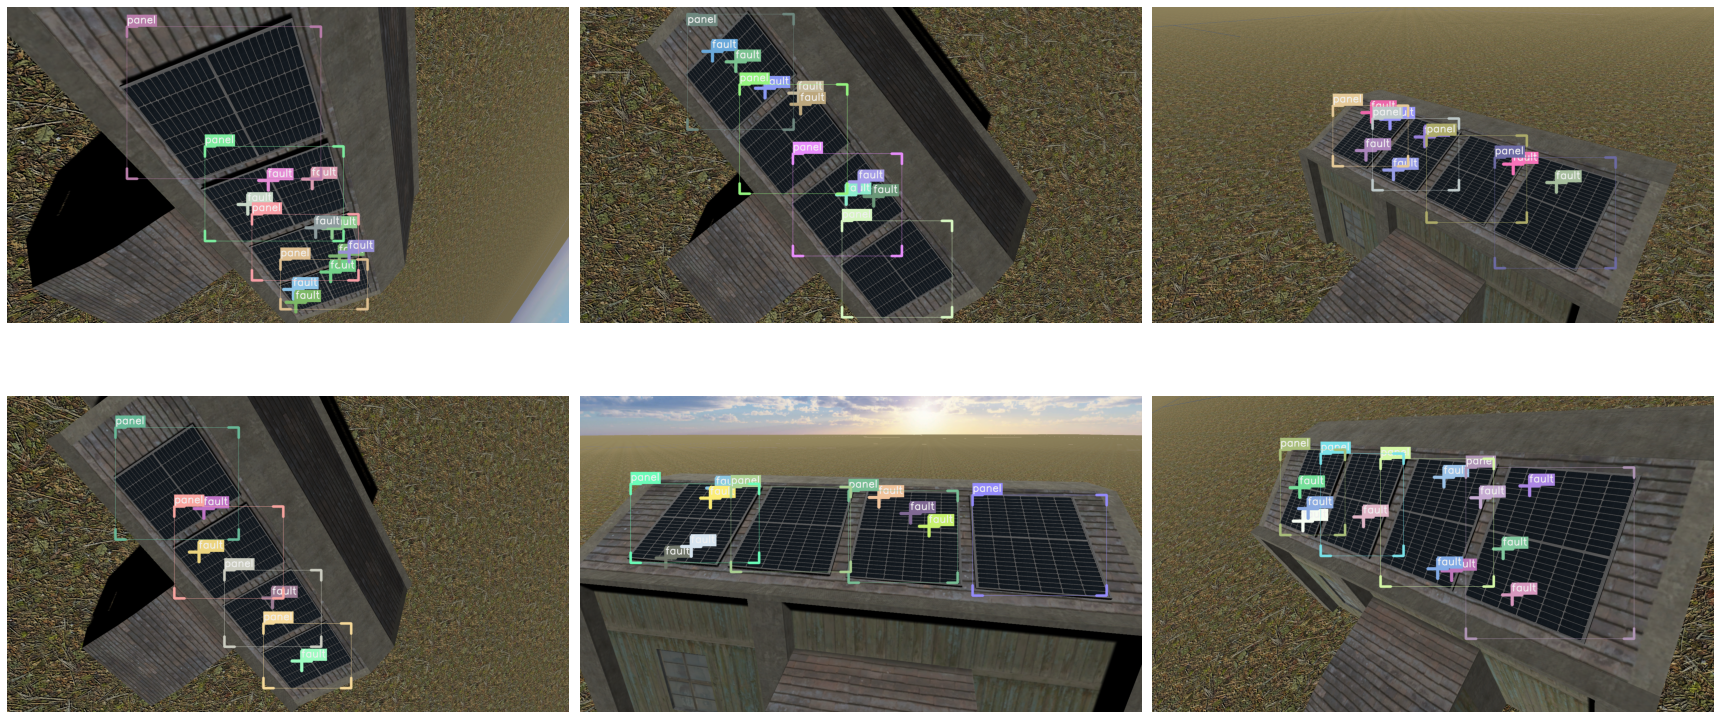

In [18]:
show_records(train_records[:6], ncols=3, class_map=class_map)

## FasterRCNN

In [16]:
train_tfms = tfms.A.Adapter([tfms.A.LongestMaxSize(224), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.LongestMaxSize(224), tfms.A.Normalize()])

In [17]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [18]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=2, shuffle=True, num_workers=4)
valid_dl = faster_rcnn.valid_dl(train_ds, batch_size=2, shuffle=False, num_workers=4)

In [19]:
backbone = faster_rcnn.backbones.resnet_fpn.resnet18()
model = faster_rcnn.model(num_classes=len(class_map), backbone=backbone)
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Efficientdet

In [19]:
img_h, img_w = 128*2, 128*4
train_tfms = tfms.A.Adapter([tfms.A.Resize(img_h, img_w), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.Resize(img_h, img_w), tfms.A.Normalize()])

In [20]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [21]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = efficientdet.valid_dl(train_ds, batch_size=16, shuffle=False, num_workers=4)

In [22]:
# model_names: tf_efficientdet_d1, tf_efficientdet_d2...
model = efficientdet.model(model_name='tf_efficientdet_lite0', num_classes=len(class_map), img_size=(img_h, img_w))

In [23]:
metrics = [COCOMetric(print_summary=False)]

In [24]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

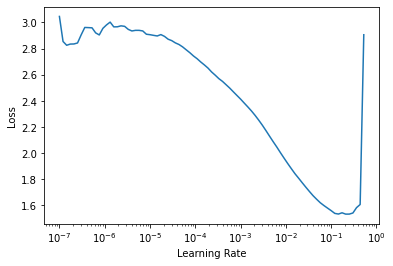

In [25]:
learn.lr_find()

In [26]:
learn.fine_tune(5, 1e-2)

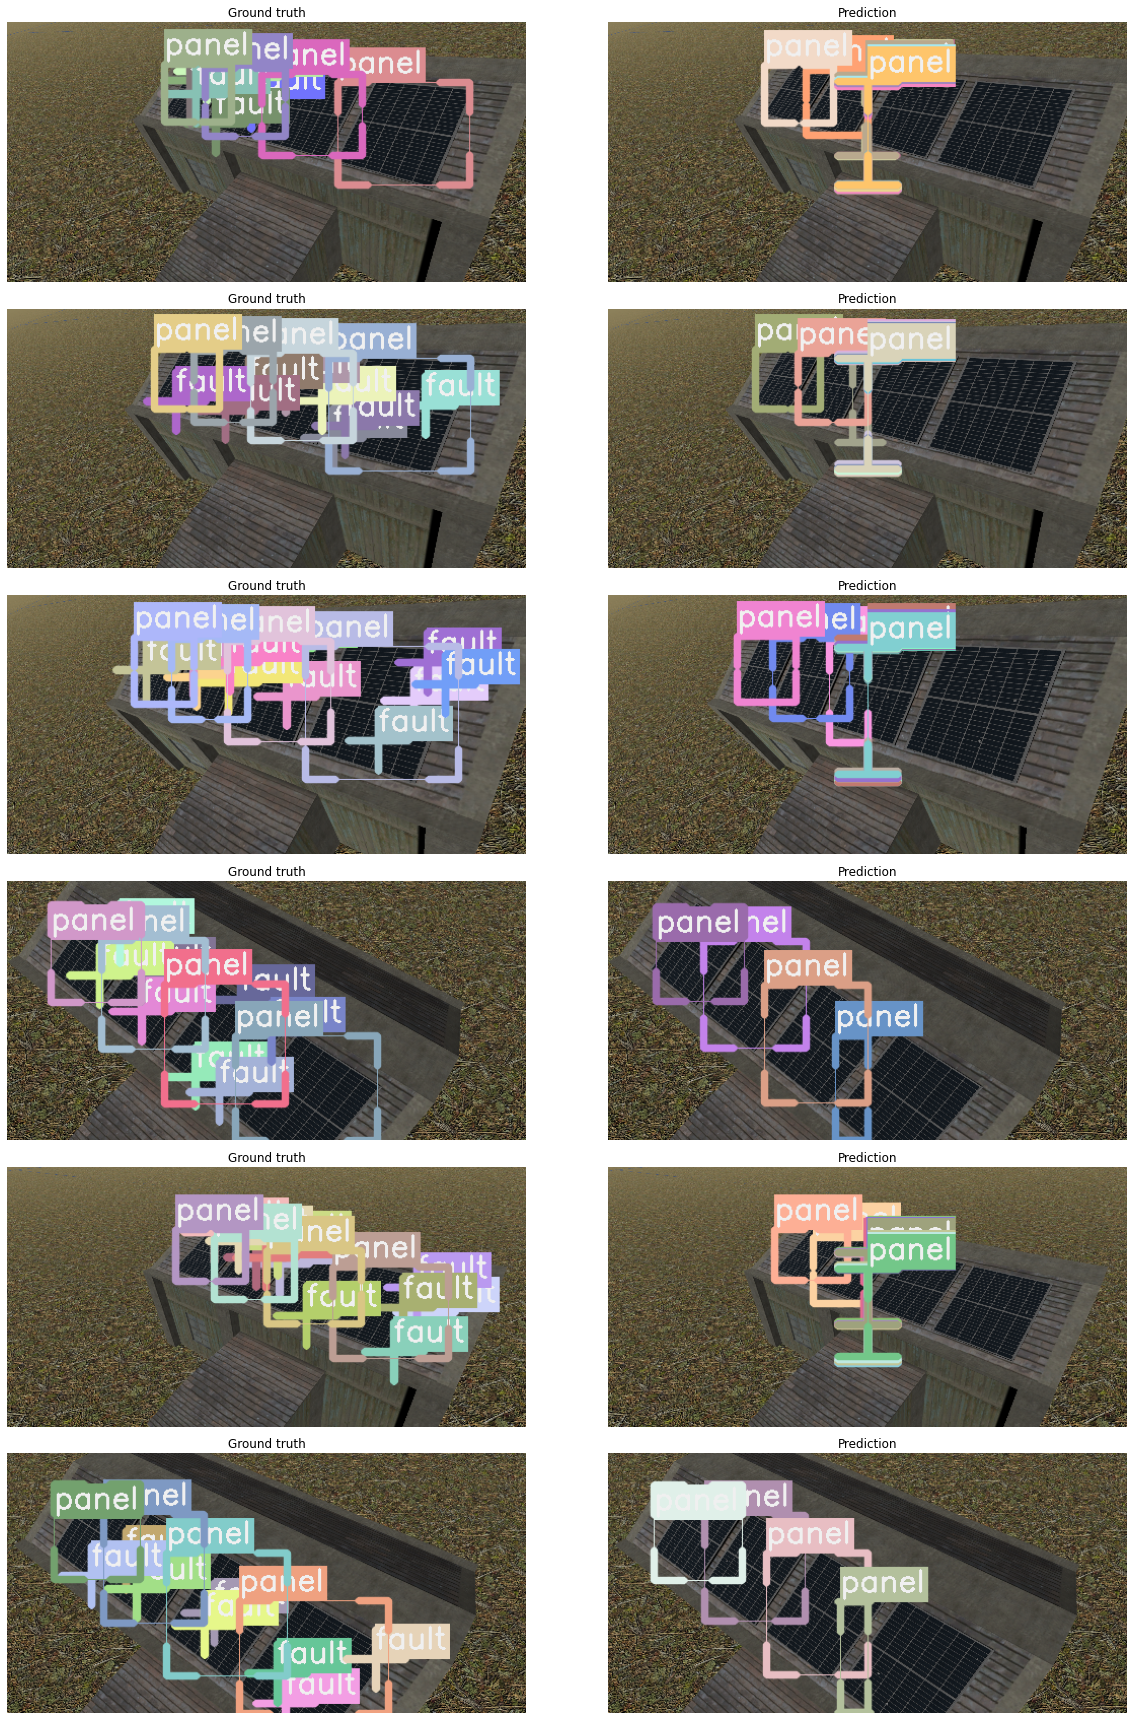

In [27]:
efficientdet.show_results(model, valid_ds, class_map=class_map)